# Find Arrhenius format for filter threshold

This script prints out Arrhenius format data to be copied to rmgpy/solver/simple.pyx def get_uni_bimolecular_threshold_rate_constant(T). Whatch out for order with reaction list in def get_filterlist_of_all_RMG_families().

In [1]:
import os
import unittest 
import numpy as np
from rmgpy import settings
from rmgpy.data.kinetics.database import KineticsDatabase
from rmgpy.data.base import DatabaseError
import numpy
from copy import deepcopy
from rmgpy.molecule.molecule import Molecule
from rmgpy.species import Species
from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics.common import KineticsError, saveEntry
from rmgpy.kinetics.arrhenius import Arrhenius

import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
path = os.path.join(settings['database.directory'], 'kinetics','families')
database = RMGDatabase()
database.load(
            path = settings['database.directory'],
            thermoLibraries = ['primaryThermoLibrary','Klippenstein_Glarborg2016','BurkeH2O2','thermo_DFT_CCSDTF12_BAC','CBS_QB3_1dHR', 'DFT_QCI_thermo'],
            transportLibraries = [],
            reactionLibraries = [],
            seedMechanisms = [],
            kineticsFamilies = 'all',
            kineticsDepositories = ['training'],
            depository = False,
        )

In [3]:
# Copy the name of the family here
fam = database.kinetics.families['Peroxyl_Disproportionation']

In [4]:
dep = fam.getTrainingDepository()

In [5]:
# Load species thermo
rxns = []
for entry in dep.entries.values():
    r = entry.item
    r.kinetics = entry.data
    for spc in r.reactants+r.products:
        if spc.thermo is None:
            spc.thermo = database.thermo.getThermoData(spc)
    rxns.append(r)

/Users/agnes/PycharmProjects/RMG-Py/rmgpy/tools/plot.py:34: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/agnes/Documents/Software/Miniconda3/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/agnes/Documents/Software/Miniconda3/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/agnes/Documents/Software/Miniconda3/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/agnes/Documents/Software/Miniconda3/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in laun

In [6]:
# Identify uni- and bimolecular reactions
kunim = []
kbim = []
for rxn in rxns:
    if len(rxn.reactants) == 1:
        kunim.append(rxn.kinetics)
    elif len(rxn.reactants) == 2:
        kbim.append(rxn.kinetics)
    if len(rxn.products) == 1:
        kunim.append(rxn.generateReverseRateCoefficient())
    elif len(rxn.products) == 2:
        kbim.append(rxn.generateReverseRateCoefficient())

In [7]:
Ts = np.linspace(300,2500,30)

In [8]:
# Unimolecular result if any
kunimaxes = []
for T in Ts:
    try:
        kvals = [k.getRateCoefficient(T) for k in kunim]
        kval = max(kvals)
        kunimaxes.append(kval)
    except:
        pass
    
try:
    arruni = Arrhenius().fitToData(Ts,np.array(kunimaxes),'s^-1')
    print arruni
    plt.semilogy(1000.0/Ts,kunimaxes)
    plt.xlabel("1000/T (1/K)")
    plt.ylabel("k 1/s")
except:
    pass

Arrhenius(A=(1.1e+06,'m^3/(mol*s)'), n=-1.05506e-14, Ea=(-4.184,'kJ/mol'), T0=(1,'K'), Tmin=(300,'K'), Tmax=(2500,'K'), comment="""Fitted to 30 data points; dA = *|/ 1, dn = +|- 1.19083e-15, dEa = +|- 8.12686e-15 kJ/mol""")


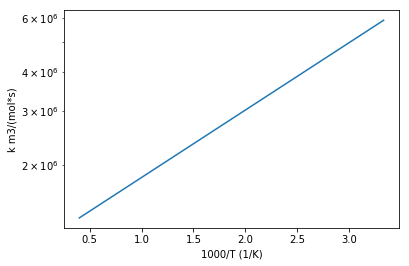

In [9]:
# Bimolecular result if any
kbimaxes = []
for T in Ts:
    try:
        kvals = [k.getRateCoefficient(T) for k in kbim]
        kval = max(kvals)
        kbimaxes.append(kval)
    except:
        pass
    
try:
    arrbi = Arrhenius().fitToData(Ts,np.array(kbimaxes),'m^3/(mol*s)')
    print arrbi
    plt.semilogy(1000.0/Ts,kbimaxes)
    plt.xlabel("1000/T (1/K)")
    plt.ylabel("k m3/(mol*s)")
except:
    pass